# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6426611.datarmor0/parcels-502027/libparcels_random_6ecae0ed-00ce-4107-a57d-d240728c02eb.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.64:45959 Dashboard: http://10.148.1.64:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


__________________
# 2. Band-integrated KE

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [5]:
# load raw spectra (zonally averaged)
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr') # should change to not 2D binned spectra, not done yet
        .rename({'E':'E_Lagrangian'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian'})
       )

ds = xr.merge([ds_L, ds_E])

E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat_bins))
f_cpd_llc = f_llc*86400/2./np.pi
E_Lagrangian

<xarray.DataArray 'E_Lagrangian' (lat_bins: 119, frequency: 1440)>
dask.array<open_dataset-742279fcc593a701564ce6cc7c64b3aaE, shape=(119, 1440), dtype=float64, chunksize=(119, 100), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

In [6]:
# KE already computed from 2D binned spectra
E = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_L = E.E

E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_E = E.E_SSUV
E_E

,Array,Chunk
Bytes,4.89 MiB,10.55 kiB
Shape,"(15, 359, 119)","(1, 45, 30)"
Count,481 Tasks,480 Chunks
Type,float64,numpy.ndarray


____________
### KE levels derived from zonally-averaged Lagrangian spectra give a relative bad agreement with Eulerian ones.
### KE levels should be calculated from 2D binned spectra at 2D bins, and then do zonal averaging.

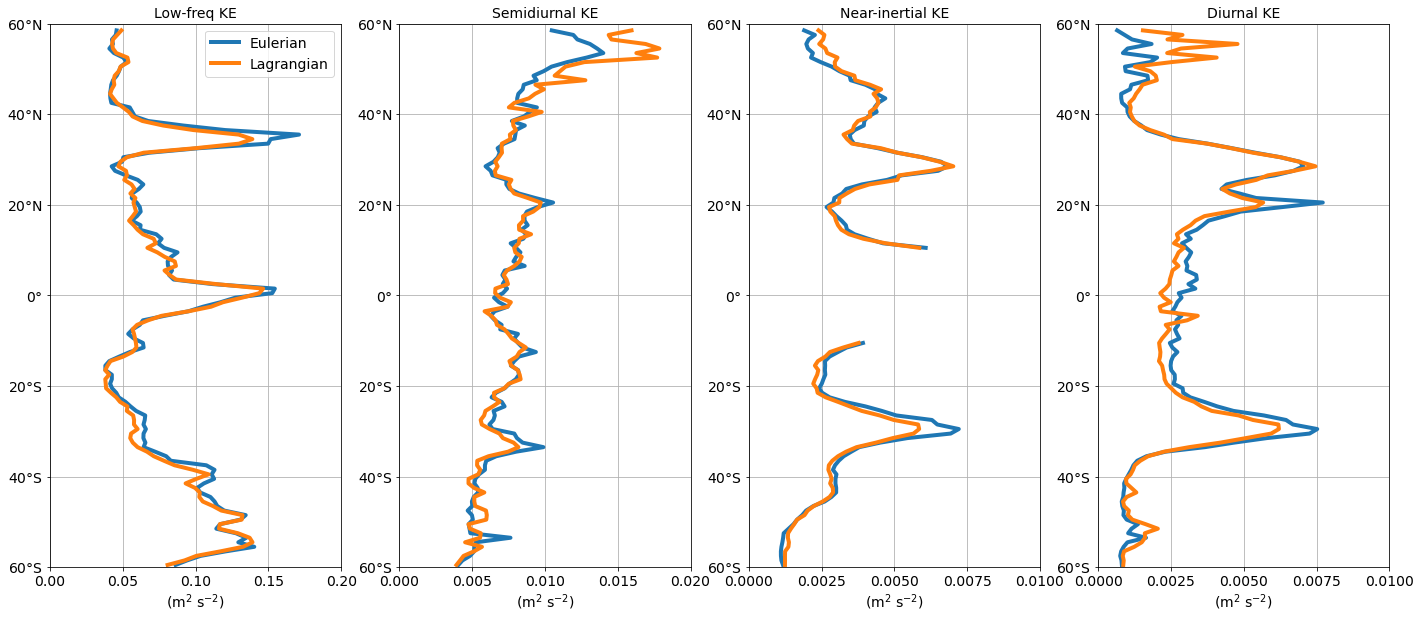

In [15]:
labels = ['Eulerian', 'Lagrangian']
font_size = 14
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(24,10))

ax = plt.subplot(141)
E_E.sel(frequency_band='low').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.2])
ax.set_xticks([0., 0.05, 0.1, 0.15, 0.2])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq KE',fontsize=font_size)

ax = plt.subplot(142)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0., 0.005, 0.01, 0.015, 0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Semidiurnal KE',fontsize=font_size)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

ax = plt.subplot(143)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_E.lat_bins)>10).plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.01])
ax.set_xticks([0., 0.0025, 0.005, 0.0075, 0.01])

# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Near-inertial KE',fontsize=font_size)

ax = plt.subplot(144)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.01])
ax.set_xticks([0., 0.0025, 0.005, 0.0075, 0.01])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Diurnal KE',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each.png')

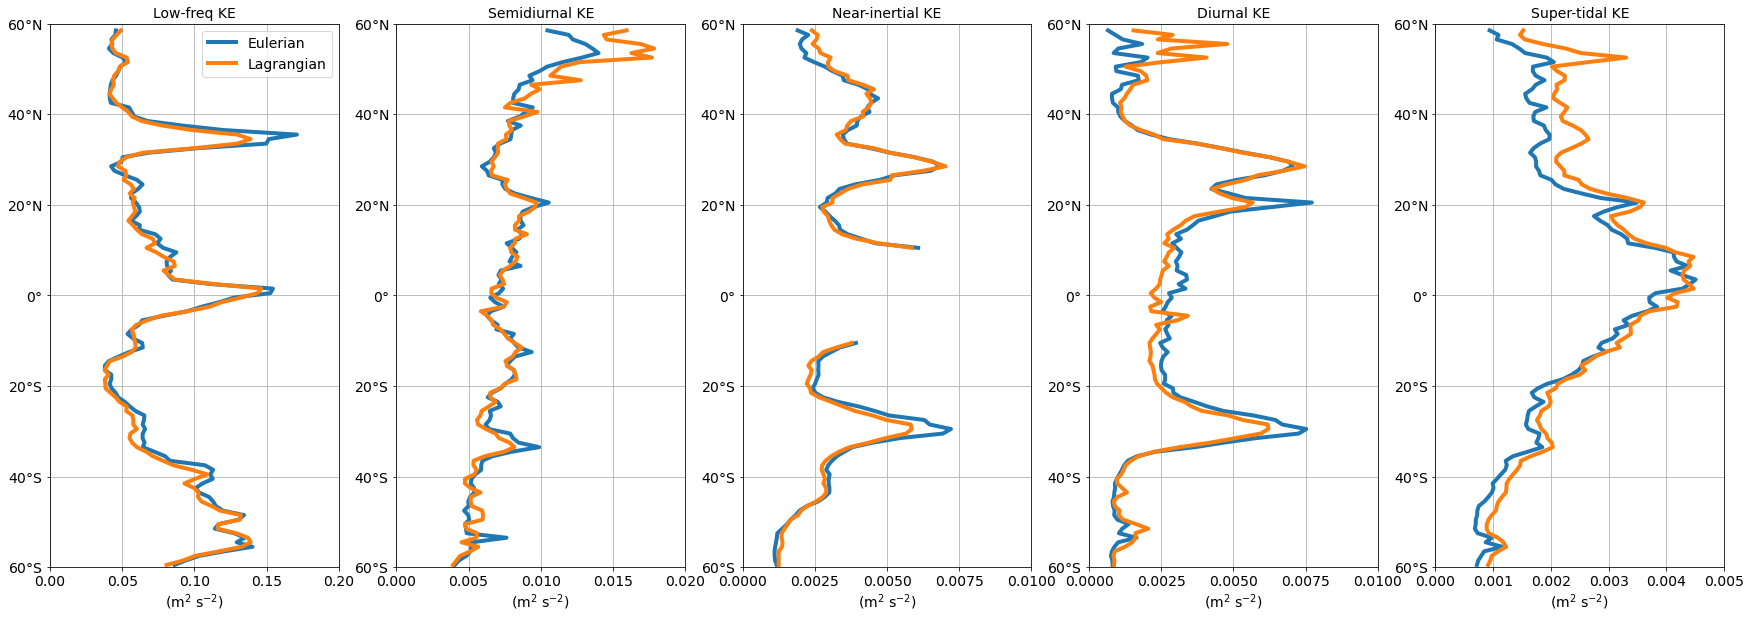

In [9]:
labels = ['Eulerian', 'Lagrangian']
font_size = 14
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(30,10))

ax = plt.subplot(151)
E_E.sel(frequency_band='low').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.2])
ax.set_xticks([0., 0.05, 0.1, 0.15, 0.2])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq KE',fontsize=font_size)

ax = plt.subplot(152)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0., 0.005, 0.01, 0.015, 0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Semidiurnal KE',fontsize=font_size)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

ax = plt.subplot(153)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_E.lat_bins)>10).plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.01])
ax.set_xticks([0., 0.0025, 0.005, 0.0075, 0.01])

# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Near-inertial KE',fontsize=font_size)

ax = plt.subplot(154)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.01])
ax.set_xticks([0., 0.0025, 0.005, 0.0075, 0.01])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Diurnal KE',fontsize=font_size)

ax = plt.subplot(155)
E_E.sel(frequency_band='supertidal').mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='supertidal').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.005])
#ax.set_xticks([0., 0.05, 0.1, 0.15, 0.2])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Super-tidal KE',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_all.png')

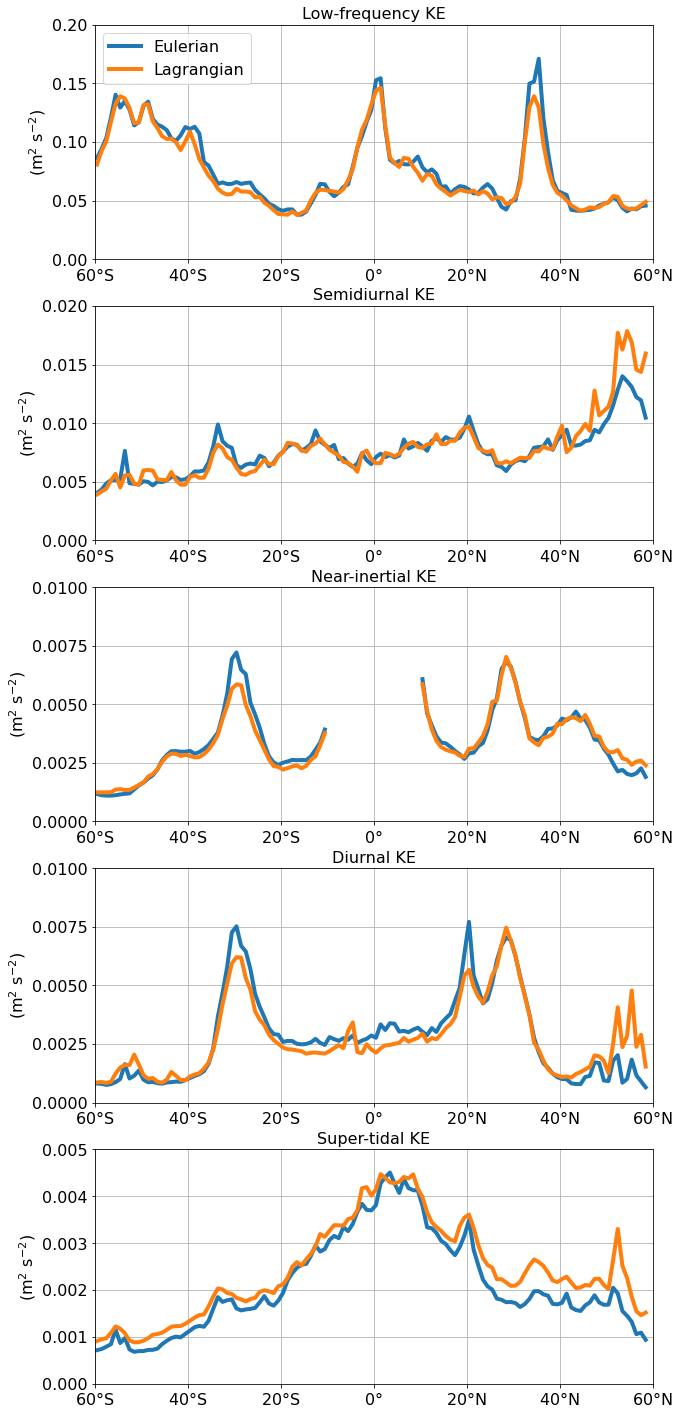

In [7]:
labels = ['Eulerian', 'Lagrangian']
font_size = 16
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(10,25))

ax = plt.subplot(511)
E_E.sel(frequency_band='low').mean('lon_bins').plot(x='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(x='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
ax.set_yticks([0., 0.05, 0.1, 0.15, 0.2])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Low-frequency KE',fontsize=font_size)

ax = plt.subplot(512)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(x='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(x='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.02])
ax.set_yticks([0., 0.005, 0.01, 0.015, 0.02])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Semidiurnal KE',fontsize=font_size)

ax = plt.subplot(513)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_E.lat_bins)>10).plot(x='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(x='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
ax.set_yticks([0., 0.0025, 0.005, 0.0075, 0.01])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Near-inertial KE',fontsize=font_size)

ax = plt.subplot(514)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(x='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(x='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
ax.set_yticks([0., 0.0025, 0.005, 0.0075, 0.01])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Diurnal KE',fontsize=font_size)

ax = plt.subplot(515)
E_E.sel(frequency_band='supertidal').mean('lon_bins').plot(x='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='supertidal').mean('lon_bins').plot(x='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.005])
#ax.set_xticks([0., 0.05, 0.1, 0.15, 0.2])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Super-tidal KE',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_horizonal.png')

_________
## bandwidth

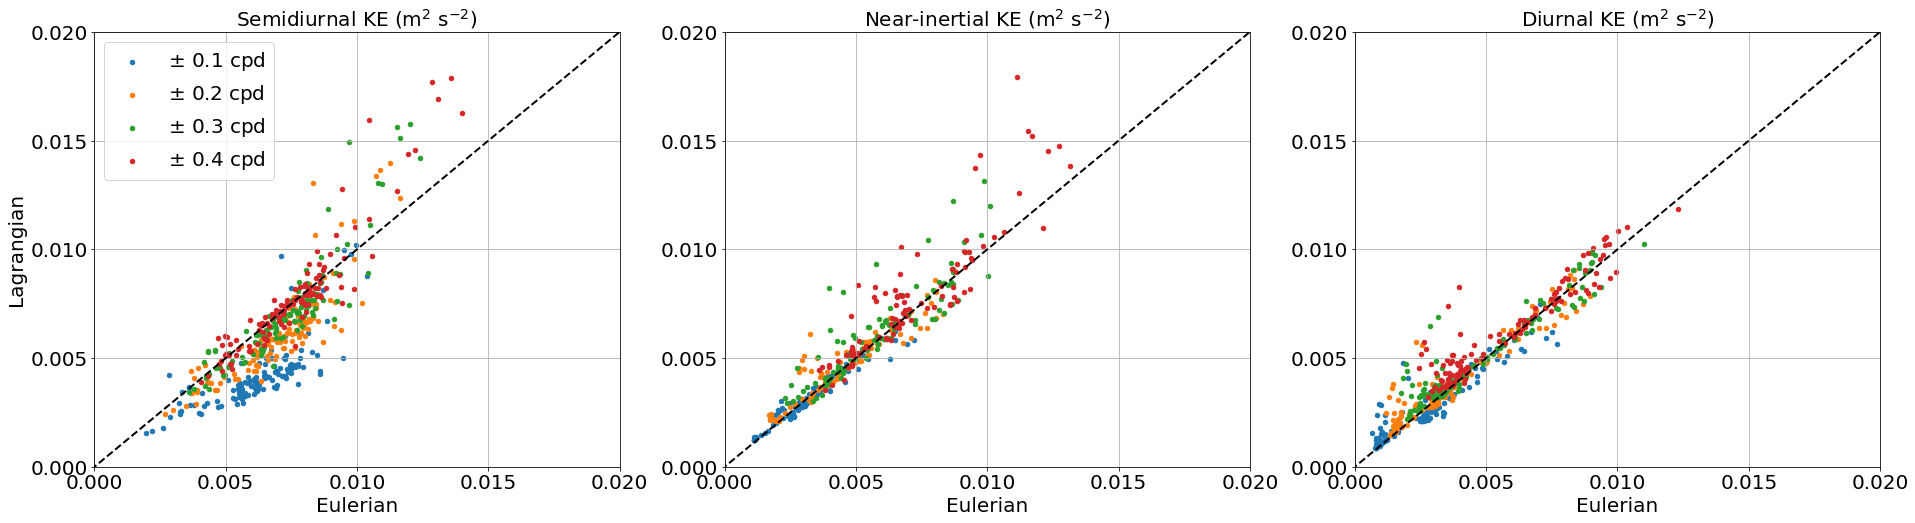

In [9]:
upper_limit= 0.2
lims =(-0.5, 0.5)
size = 20
font_size=20
fig, ax = plt.subplots(1,1,figsize=(32,8))
labels = ['$\pm$ 0.1 cpd', '$\pm$ 0.2 cpd','$\pm$ 0.3 cpd','$\pm$ 0.4 cpd',]

ax = plt.subplot(131)
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), s=size, label=labels[0])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'), s=size, label=labels[1])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'), s=size, label=labels[2])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), s=size, label=labels[3])
ax.legend(prop={'size': font_size}); ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Semidiurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)

ax = plt.subplot(132)
ax.scatter( E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)

ax = plt.subplot(133)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_bandwidth_scatter.png')

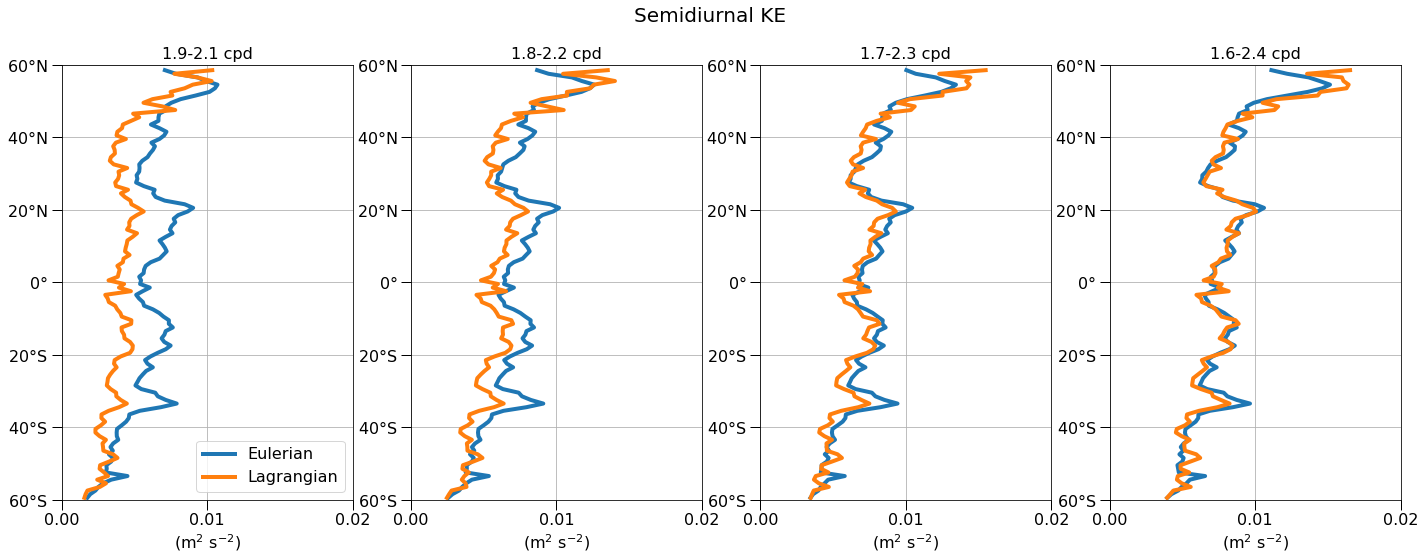

In [13]:
# compare each component by applying windowing
labels = ['Eulerian', 'Lagrangian']

font_size = 16
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle("Semidiurnal KE",fontsize=font_size+4)

ax = plt.subplot(141)
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size}); 
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.9-2.1 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(142)
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.8) & (abs(E_Eulerian.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(y='lat_bins',color='tab:blue', linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(y='lat_bins',color='tab:orange', linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.8-2.2 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(143)
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.7) & (abs(E_Eulerian.frequency)<2.3) , other=0.)*df).sum(dim='frequency').plot(y='lat_bins',color='tab:blue', linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(y='lat_bins',color='tab:orange', linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.7-2.3 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(144)
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.6) & (abs(E_Eulerian.frequency)<2.4) , other=0.)*df).sum(dim='frequency').plot(y='lat_bins',color='tab:blue', linewidth=4) # total energy
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(y='lat_bins',color='tab:orange', linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.6-2.4 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_bandwidth_semidiurnal.png')

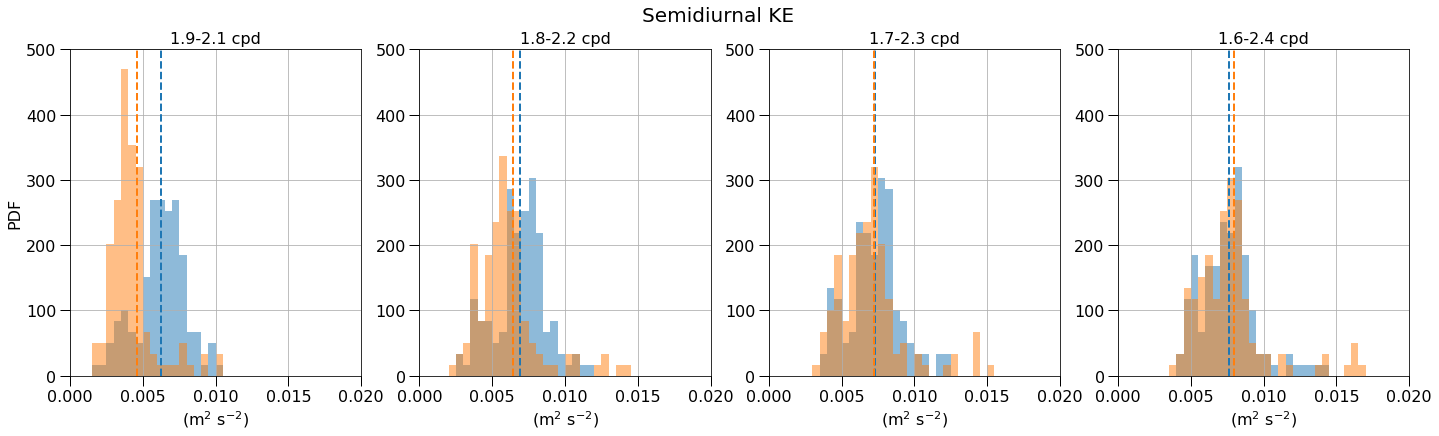

In [23]:
labels = ['Eulerian', 'Lagrangian']

font_size = 16
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(24,6))
fig.suptitle("Semidiurnal KE",fontsize=font_size+4)

ax = plt.subplot(141)
(E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=True, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=True, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').mean(),E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').mean(),E_L.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('PDF',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.9-2.1 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(142)
(E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').mean(),E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').mean(),E_L.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.8-2.2 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(143)
(E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').mean(),E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='semidiurnal_0dot3').where(E_L<upper_limit).mean('lon_bins').mean(),E_L.sel(frequency_band='semidiurnal_0dot3').where(E_L<upper_limit).mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.7-2.3 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(144)
(E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, histtype='bar', alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').mean(),E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='semidiurnal_0dot4').where(E_L<upper_limit).mean('lon_bins').mean(),E_L.sel(frequency_band='semidiurnal_0dot4').where(E_L<upper_limit).mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('1.6-2.4 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)


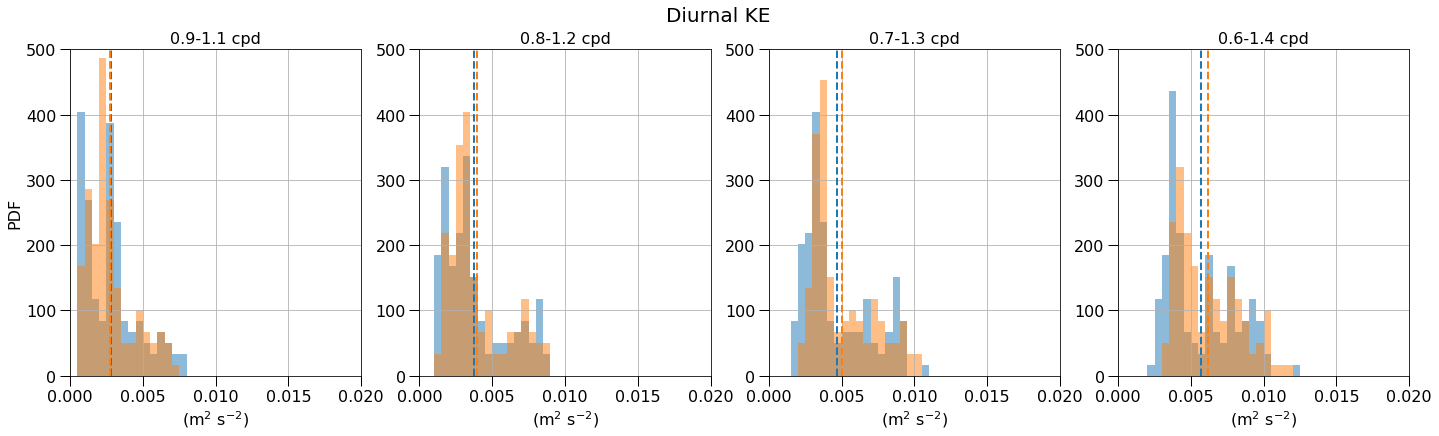

In [24]:
labels = ['Eulerian', 'Lagrangian']

font_size = 16
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(24,6))
fig.suptitle("Diurnal KE",fontsize=font_size+4)

ax = plt.subplot(141)
(E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='diurnal_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').mean(),E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').mean(),E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('PDF',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('0.9-1.1 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(142)
(E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='diurnal_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins').mean(),E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins').mean(),E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('0.8-1.2 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(143)
(E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='diurnal_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins').mean(),E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins').mean(),E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('0.7-1.3 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(144)
(E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='diurnal_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, histtype='bar', alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins').mean(),E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins').mean(),E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('0.6-1.4 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)


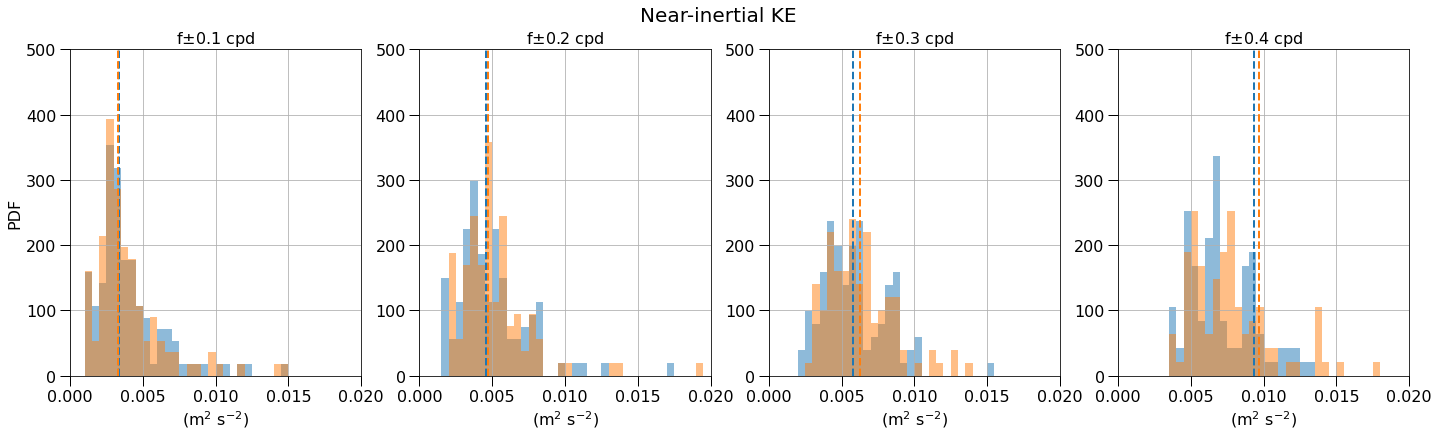

In [26]:
# compare each component by applying windowing
labels = ['Eulerian', 'Lagrangian']

font_size = 16
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(24,6))
fig.suptitle("Near-inertial KE",fontsize=font_size+4)

ax = plt.subplot(141)
(E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='inertial_0dot1').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot1').mean('lon_bins').mean(),E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot1').mean('lon_bins').mean(),E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot1').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('PDF',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('f$\pm$0.1 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(142)
(E_E.sel(frequency_band='inertial_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='inertial_0dot2').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot2').mean('lon_bins').mean(),E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot2').mean('lon_bins').mean(),E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot2').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('f$\pm$0.2 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(143)
(E_E.sel(frequency_band='inertial_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='inertial_0dot3').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot3').mean('lon_bins').mean(),E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot3').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot3').mean('lon_bins').mean(),E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot3').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('f$\pm$0.3 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(144)
(E_E.sel(frequency_band='inertial_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, alpha = 0.5)
(E_L.where(E_L<upper_limit).sel(frequency_band='inertial_0dot4').mean('lon_bins')).plot.hist(bins=np.arange(0,0.02,0.0005),density=True, stacked=False, histtype='bar', alpha = 0.5)
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_ylim([0,500])
ax.set_yticks([0,100,200,300,400,500])
ax.grid()
ax.plot([E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot4').mean('lon_bins').mean(),E_E.where(np.abs(E_E.lat_bins)>10).sel(frequency_band='inertial_0dot4').mean('lon_bins').mean()],[0.,500],color='tab:blue', ls='--', linewidth=2)  # S2
ax.plot([E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot4').mean('lon_bins').mean(),E_L.where(np.abs(E_L.lat_bins)>10).sel(frequency_band='inertial_0dot4').mean('lon_bins').mean()],[0.,500],color='tab:orange', ls='--', linewidth=2)  # S2
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('f$\pm$0.4 cpd',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)


________________
# Statistics

In [7]:
E_L.load()
E_E.load()

<xarray.DataArray 'E_SSUV' (frequency_band: 15, lon_bins: 359, lat_bins: 119)>
array([[[0.11356987, 0.0854319 , 0.08433392, ..., 0.03935991,
         0.03226005, 0.05468373],
        [0.07362469, 0.10083878, 0.06703281, ..., 0.03194886,
         0.03374163, 0.0699858 ],
        [0.07886605, 0.08765426, 0.06720451, ..., 0.04151093,
         0.04079079, 0.10551524],
        ...,
        [0.06368682, 0.07795898, 0.14607621, ..., 0.05095825,
         0.03900531, 0.05186075],
        [0.0641161 , 0.06205942, 0.16986746, ..., 0.05548319,
         0.04556351, 0.0450061 ],
        [0.0731313 , 0.0570593 , 0.14047941, ..., 0.04218542,
         0.03671827, 0.05285981]],

       [[0.10613983, 0.07836404, 0.07690842, ..., 0.01794665,
         0.01616341, 0.02905574],
        [0.0666888 , 0.09313183, 0.060576  , ..., 0.01567107,
         0.01892573, 0.05842266],
        [0.07233278, 0.0800853 , 0.06069765, ..., 0.01697683,
         0.02124967, 0.08757708],
...
        [0.00218253, 0.00185346, 0.00214828, ..., 0.01985303,
         0.01574924, 0.02084589],
        [0.00186786, 0.00178688, 0.00180971, ..., 0.02859868,
         0.01782198, 0.02012962],
        [0.00168642, 0.00180551, 0.00175163, ..., 0.0128122 ,
         0.01290123, 0.029405  ]],

       [[0.00230562, 0.00206345, 0.00204419, ..., 0.0182261 ,
         0.01299853, 0.02190568],
        [0.00245234, 0.00213488, 0.00194623, ..., 0.01290528,
         0.01164077, 0.00762415],
        [0.00223679, 0.00205203, 0.00203967, ..., 0.02078023,
         0.01580042, 0.0124029 ],
        ...,
        [0.00240539, 0.00213571, 0.00244211, ..., 0.02325287,
         0.0181417 , 0.02188832],
        [0.002101  , 0.00206273, 0.00211461, ..., 0.03137342,
         0.02140585, 0.02125535],
        [0.00192462, 0.00208051, 0.00212254, ..., 0.0144275 ,
         0.01512738, 0.03039066]]])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [55]:
E_L.frequency_band

<xarray.DataArray 'frequency_band' (frequency_band: 14)>
array(['total', 'low', 'diurnal_0dot1', 'diurnal_0dot2', 'diurnal_0dot3',
       'diurnal_0dot4', 'semidiurnal_0dot1', 'semidiurnal_0dot2',
       'semidiurnal_0dot3', 'semidiurnal_0dot4', 'inertial_0dot1',
       'inertial_0dot2', 'inertial_0dot3', 'inertial_0dot4'], dtype=object)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

## Correlation 

In [56]:
# zonal average
R = xr.corr(E_L.mean('lon_bins'),
            E_E.mean('lon_bins'),
            dim=['lat_bins']
           )
R.values

array([0.96977316, 0.98006227, 0.92977574, 0.94420776, 0.94334517,
       0.9351458 , 0.61337951, 0.74211037, 0.80442599, 0.85317599,
       0.99811028, 0.99784483, 0.99789072, 0.99603856])

In [60]:
# global grid
R = xr.corr(E_L,
            E_E,
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.82305868, 0.82850987, 0.71205043, 0.7535519 , 0.76845071,
       0.77031097, 0.35707227, 0.42035523, 0.45365219, 0.47283877,
       0.83777441, 0.83754816, 0.83832456, 0.82403011])

In [59]:
# zonal average (exclude equatorial region)
R = xr.corr(E_L.mean('lon_bins').where(np.abs(E_L.lat_bins)>15),
            E_E.mean('lon_bins').where(np.abs(E_E.lat_bins)>15),
            dim=['lat_bins']
           )
R.values

array([0.96837948, 0.98066979, 0.94150371, 0.94784133, 0.94138936,
       0.92189507, 0.67243257, 0.78130124, 0.83759348, 0.8829473 ,
       0.97568892, 0.92858213, 0.86238244, 0.89971512])

In [61]:
# global grid (exclude equatorial region)
R = xr.corr(E_L.where(np.abs(E_L.lat_bins)>15),
            E_E.where(np.abs(E_E.lat_bins)>15),
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.84315854, 0.85443463, 0.74691576, 0.77724786, 0.78544841,
       0.77985547, 0.42522879, 0.49368823, 0.52473551, 0.54236642,
       0.84589033, 0.83333659, 0.71771398, 0.63122448])

Text(0.5, 1.0, '')

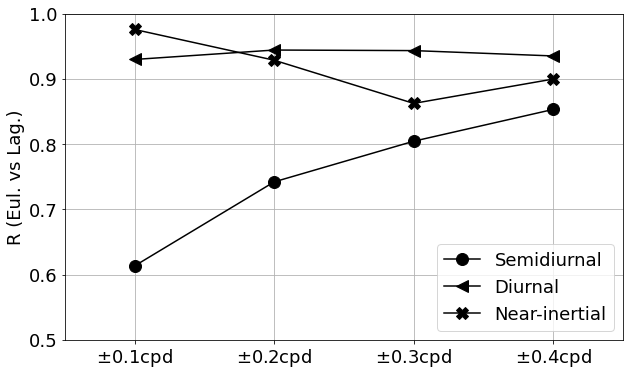

In [13]:
R_SD = [0.61337951, 0.74211037, 0.80442599, 0.85317599]
R_NI = [0.97568892, 0.92858213, 0.86238244, 0.89971512]
R_D =  [0.92977574, 0.94420776, 0.94334517, 0.9351458]
marker_size = 12

labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(R_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(R_D, '-<',label=labels[2],markersize=marker_size,color='black')
plt.plot(R_NI, '-X',label=labels[1],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.5,1])
ax.grid()
ax.set_ylabel('R (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Correlation_bandwidth.png')

Text(0.5, 1.0, '')

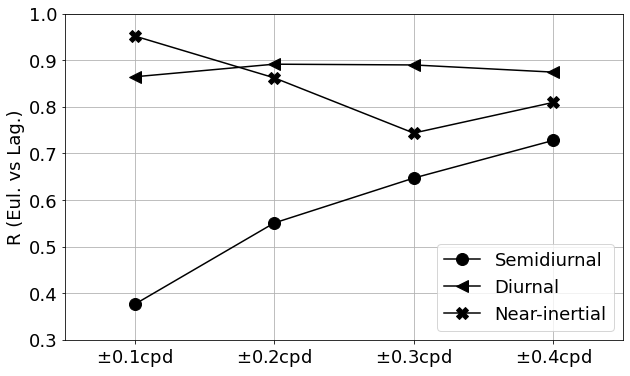

In [10]:
R_SD = [0.61337951**2, 0.74211037**2, 0.80442599**2, 0.85317599**2]
R_NI = [0.97568892**2, 0.92858213**2, 0.86238244**2, 0.89971512**2]
R_D =  [0.92977574**2, 0.94420776**2, 0.94334517**2, 0.9351458**2]
marker_size = 12

labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(R_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(R_D, '-<',label=labels[2],markersize=marker_size,color='black')
plt.plot(R_NI, '-X',label=labels[1],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.3,1])
ax.grid()
ax.set_ylabel('R (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Correlation_bandwidth.png')

## Regression coefficient

In [7]:
upper_limit = 0.2
x = E_L.where(E_L<upper_limit).mean('lon_bins')
y = E_E.mean('lon_bins')

In [8]:
regression_coef = (x*y).mean('lat_bins')/(x**2).mean('lat_bins')
regression_coef

<xarray.DataArray (frequency_band: 15)>
dask.array<truediv, shape=(15,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

In [9]:
rc_D = [regression_coef.sel(frequency_band='diurnal_0dot1').values,
        regression_coef.sel(frequency_band='diurnal_0dot2').values,
        regression_coef.sel(frequency_band='diurnal_0dot3').values,
        regression_coef.sel(frequency_band='diurnal_0dot4').values]

rc_SD = [regression_coef.sel(frequency_band='semidiurnal_0dot1').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot2').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot3').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot4').values]

In [10]:
regression_coef_NI = (x.where(np.abs(x.lat_bins)>15)*y.where(np.abs(y.lat_bins)>15)).mean('lat_bins')/(x**2).where(np.abs(x.lat_bins)>15).mean('lat_bins')
regression_coef_NI

<xarray.DataArray (frequency_band: 15)>
dask.array<truediv, shape=(15,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

In [11]:
rc_NI = [regression_coef_NI.sel(frequency_band='inertial_0dot1').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot2').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot3').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot4').values]

Text(0.5, 1.0, '')

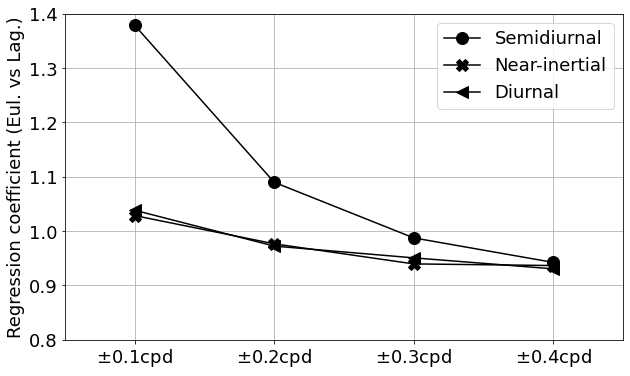

In [31]:
labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(rc_SD, '-o',label=labels[0],markersize=12,color='black')
plt.plot(rc_NI, '-X',label=labels[1],markersize=12,color='black')
plt.plot(rc_D, '-<',label=labels[2],markersize=12,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.8,1.4])
ax.grid()
ax.set_ylabel('Regression coefficient (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

## slope

In [46]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [47]:
ds_E = xr.merge([E_E.rename('E_E'),E_L.rename('E_L')])
ds_E
ds_E.load()

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_E             (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_L             (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 60), meta=np.ndarray>

In [68]:
upper_limit = 0.2
slopes = xr.apply_ufunc(linear_trend,
                        ds_E.E_E.where(ds_E.E_E<upper_limit).mean('lon_bins'), 
                        ds_E.E_L.where(ds_E.E_L<upper_limit).mean('lon_bins'),
                        vectorize=True,
                        input_core_dims=[['lat_bins'], ['lat_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray (frequency_band: 14)>
array([0.95592659, 0.99804012, 0.81329705, 0.86543798, 0.86760624,
       0.86005351, 0.71736041, 1.04239509, 1.1893611 , 1.2615038 ,
       0.93539235, 0.94082078, 0.93972334, 0.94657946])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

Text(0.5, 1.0, '')

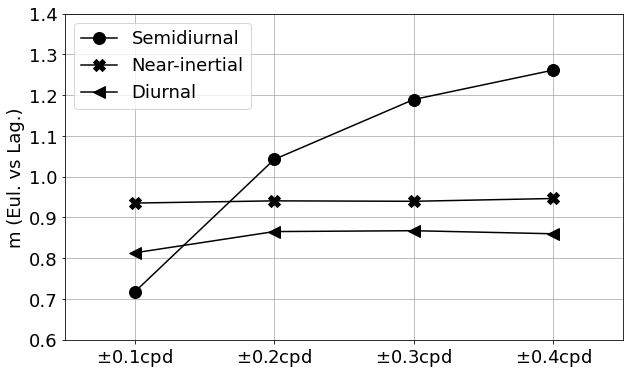

In [77]:
m_SD = [0.71736041, 1.04239509, 1.1893611 , 1.2615038]
m_NI = [0.93539235, 0.94082078, 0.93972334, 0.94657946]
m_D =  [0.81329705, 0.86543798, 0.86760624, 0.86005351]

labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(m_SD, '-o',label=labels[0],markersize=12,color='black')
plt.plot(m_NI, '-X',label=labels[1],markersize=12,color='black')
plt.plot(m_D, '-<',label=labels[2],markersize=12,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.6,1.4])
ax.grid()
ax.set_ylabel('m (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Correlation_bandwidth.png')

## RMSE

In [121]:
rmse = np.sqrt(((E_E.mean('lon_bins')-E_L.where(E_L<upper_limit).mean('lon_bins'))**2).sum('lat_bins')/119)
rmse.values

array([0.02997995, 0.02791539, 0.00068269, 0.00074657, 0.00084595,
       0.00097811, 0.00229515, 0.00143207, 0.00109623, 0.00108246,
       0.00734851, 0.00823839, 0.00898233, 0.00964106])

In [122]:
# exclude equtorial
rmse = np.sqrt(((E_E.where(np.abs(E_E.lat_bins)>15).mean('lon_bins')-E_L.where(np.abs(E_L.lat_bins)>15).where(E_L<upper_limit).mean('lon_bins'))**2).sum('lat_bins')/119)
rmse.values

array([0.0278779 , 0.02609933, 0.00063318, 0.00073277, 0.00082861,
       0.00095004, 0.00188937, 0.00126575, 0.00104341, 0.00105179,
       0.00030586, 0.0005947 , 0.00097533, 0.00088564])

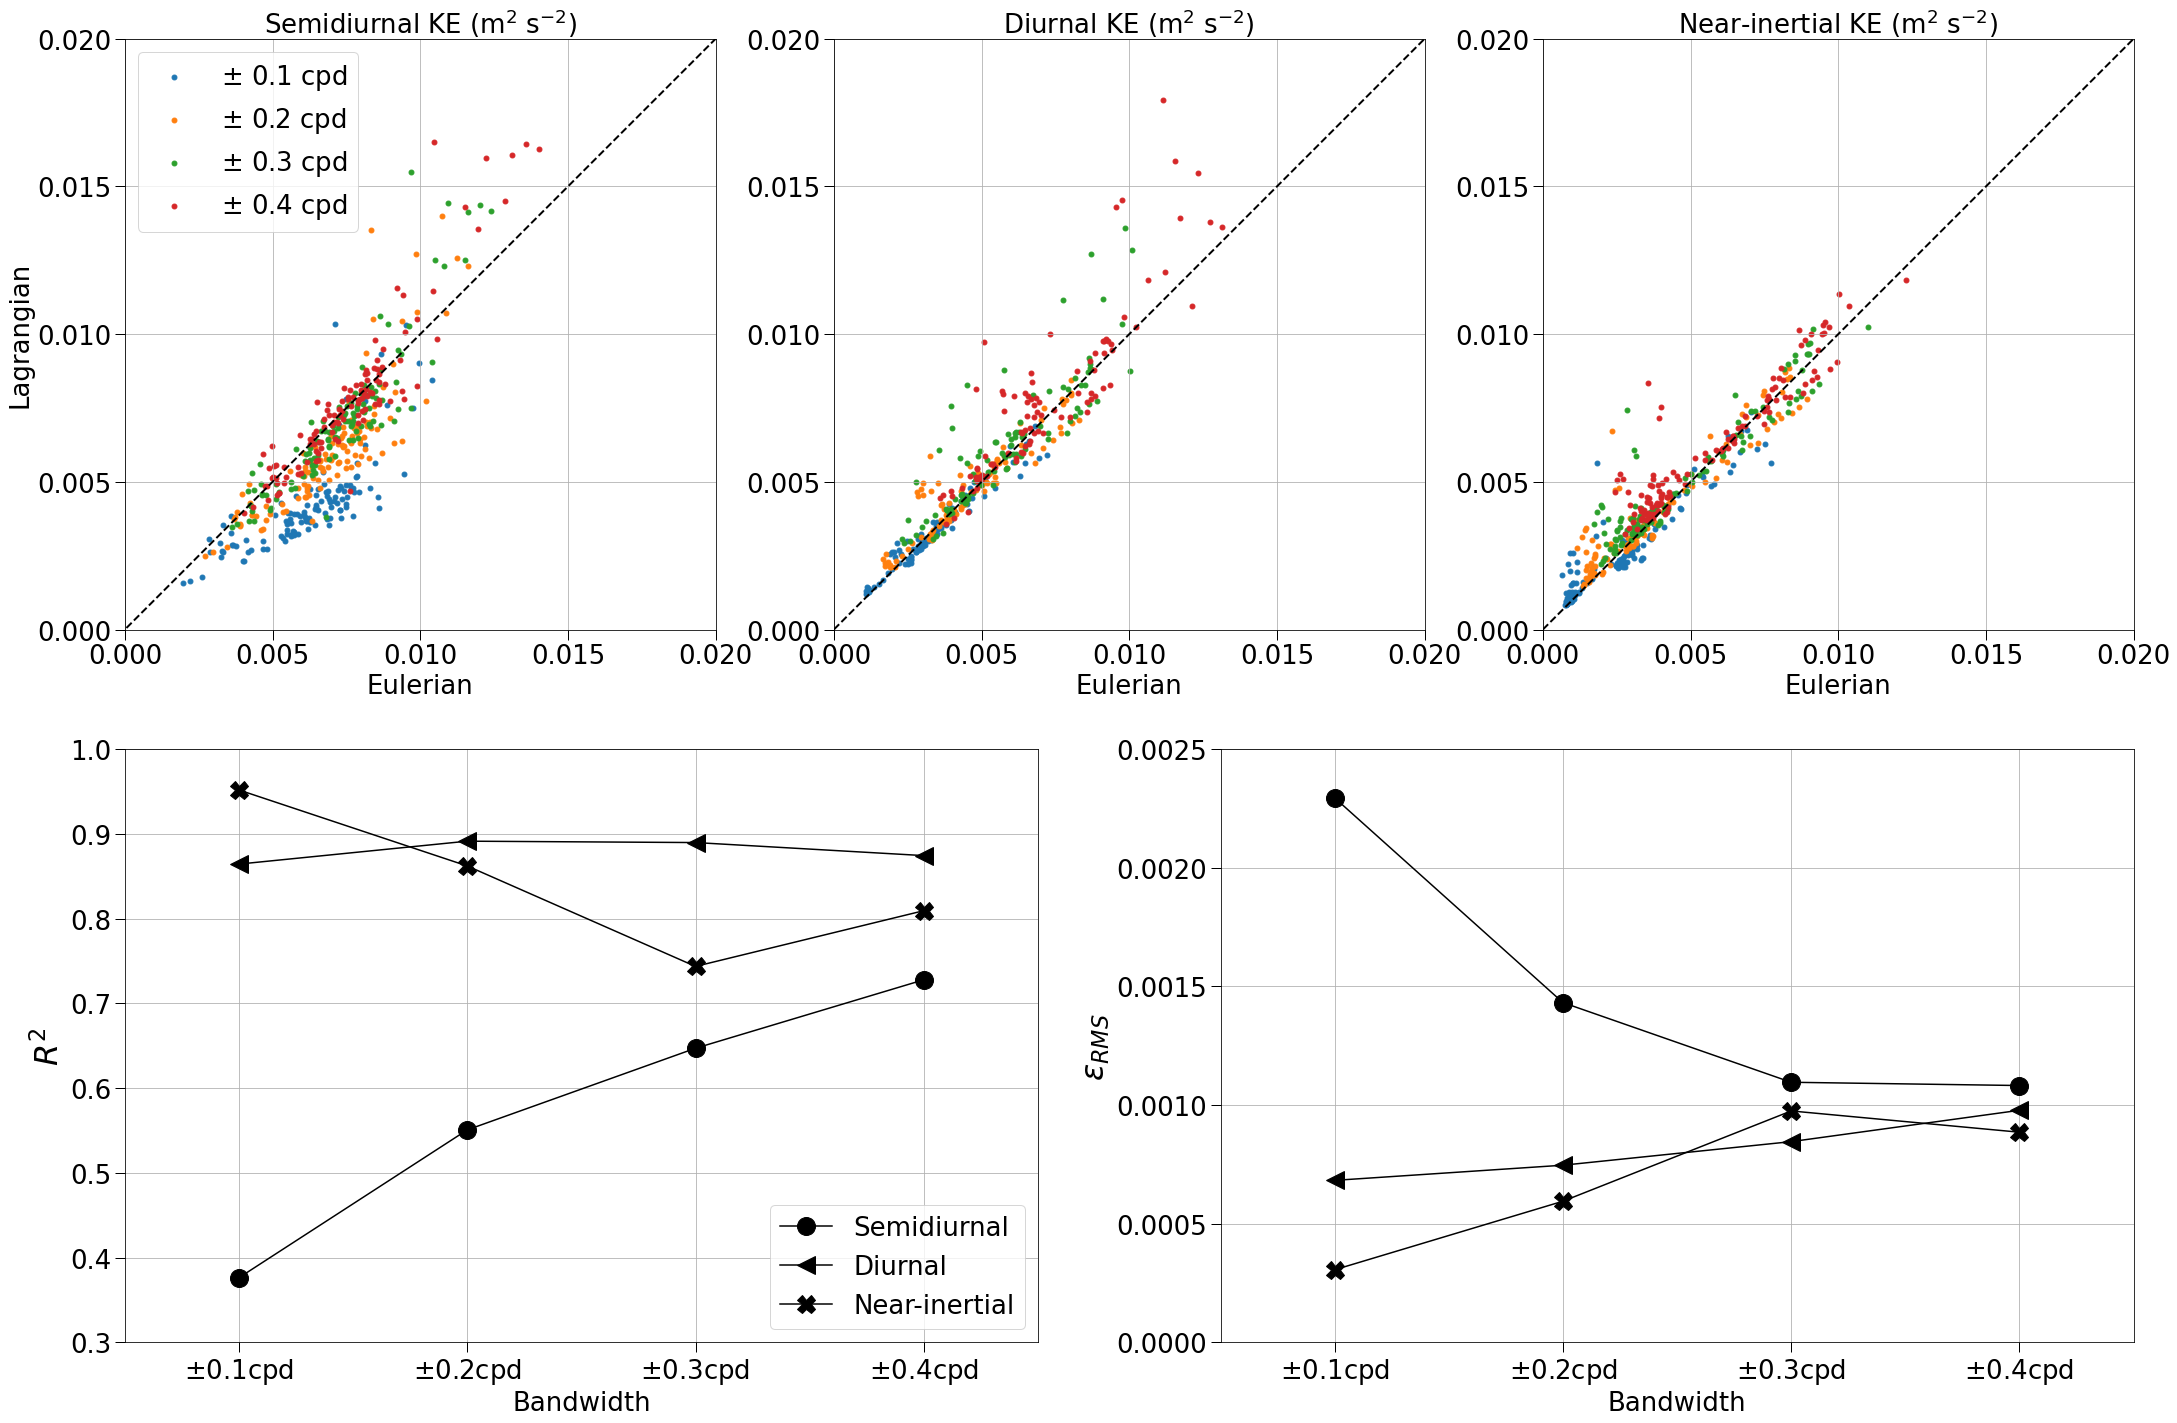

In [14]:
upper_limit= 0.2
lims =(-0.5, 0.5)
size = 24
font_size = 26
marker_size = 18
fig, ax = plt.subplots(1,1,figsize=(36,24))
labels = ['$\pm$ 0.1 cpd', '$\pm$ 0.2 cpd','$\pm$ 0.3 cpd','$\pm$ 0.4 cpd',]

ax = plt.subplot(231)
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), s=size, label=labels[0])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'), s=size, label=labels[1])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'), s=size, label=labels[2])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), s=size, label=labels[3])
ax.legend(prop={'size': font_size}); ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Semidiurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(232)
ax.scatter( E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(233)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

R_SD = [0.61337951**2, 0.74211037**2, 0.80442599**2, 0.85317599**2]
R_NI = [0.97568892**2, 0.92858213**2, 0.86238244**2, 0.89971512**2]
R_D =  [0.92977574**2, 0.94420776**2, 0.94334517**2, 0.9351458**2]
labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
ax = plt.subplot(223)
plt.plot(R_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(R_D, '-<',label=labels[2],markersize=marker_size,color='black')
plt.plot(R_NI, '-X',label=labels[1],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.3,1])
ax.grid()
ax.set_ylabel('$R^2$',fontsize=font_size+6)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower right', prop={'size': font_size})
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

RMSE_SD = [0.00229515, 0.00143207, 0.00109623, 0.00108246]
RMSE_NI = [0.00030586, 0.0005947 , 0.00097533, 0.00088564]
RMSE_D =  [0.00068269, 0.00074657, 0.00084595, 0.00097811]
ax = plt.subplot(224)
plt.plot(RMSE_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(RMSE_D, '-<',label=labels[2],markersize=marker_size,color='black')
plt.plot(RMSE_NI, '-X',label=labels[1],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.,0.0025])
ax.grid()
ax.set_ylabel('$\epsilon_{RMS}$',fontsize=font_size+6)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_bandwidth_scatter_correlation_RMSE.png')

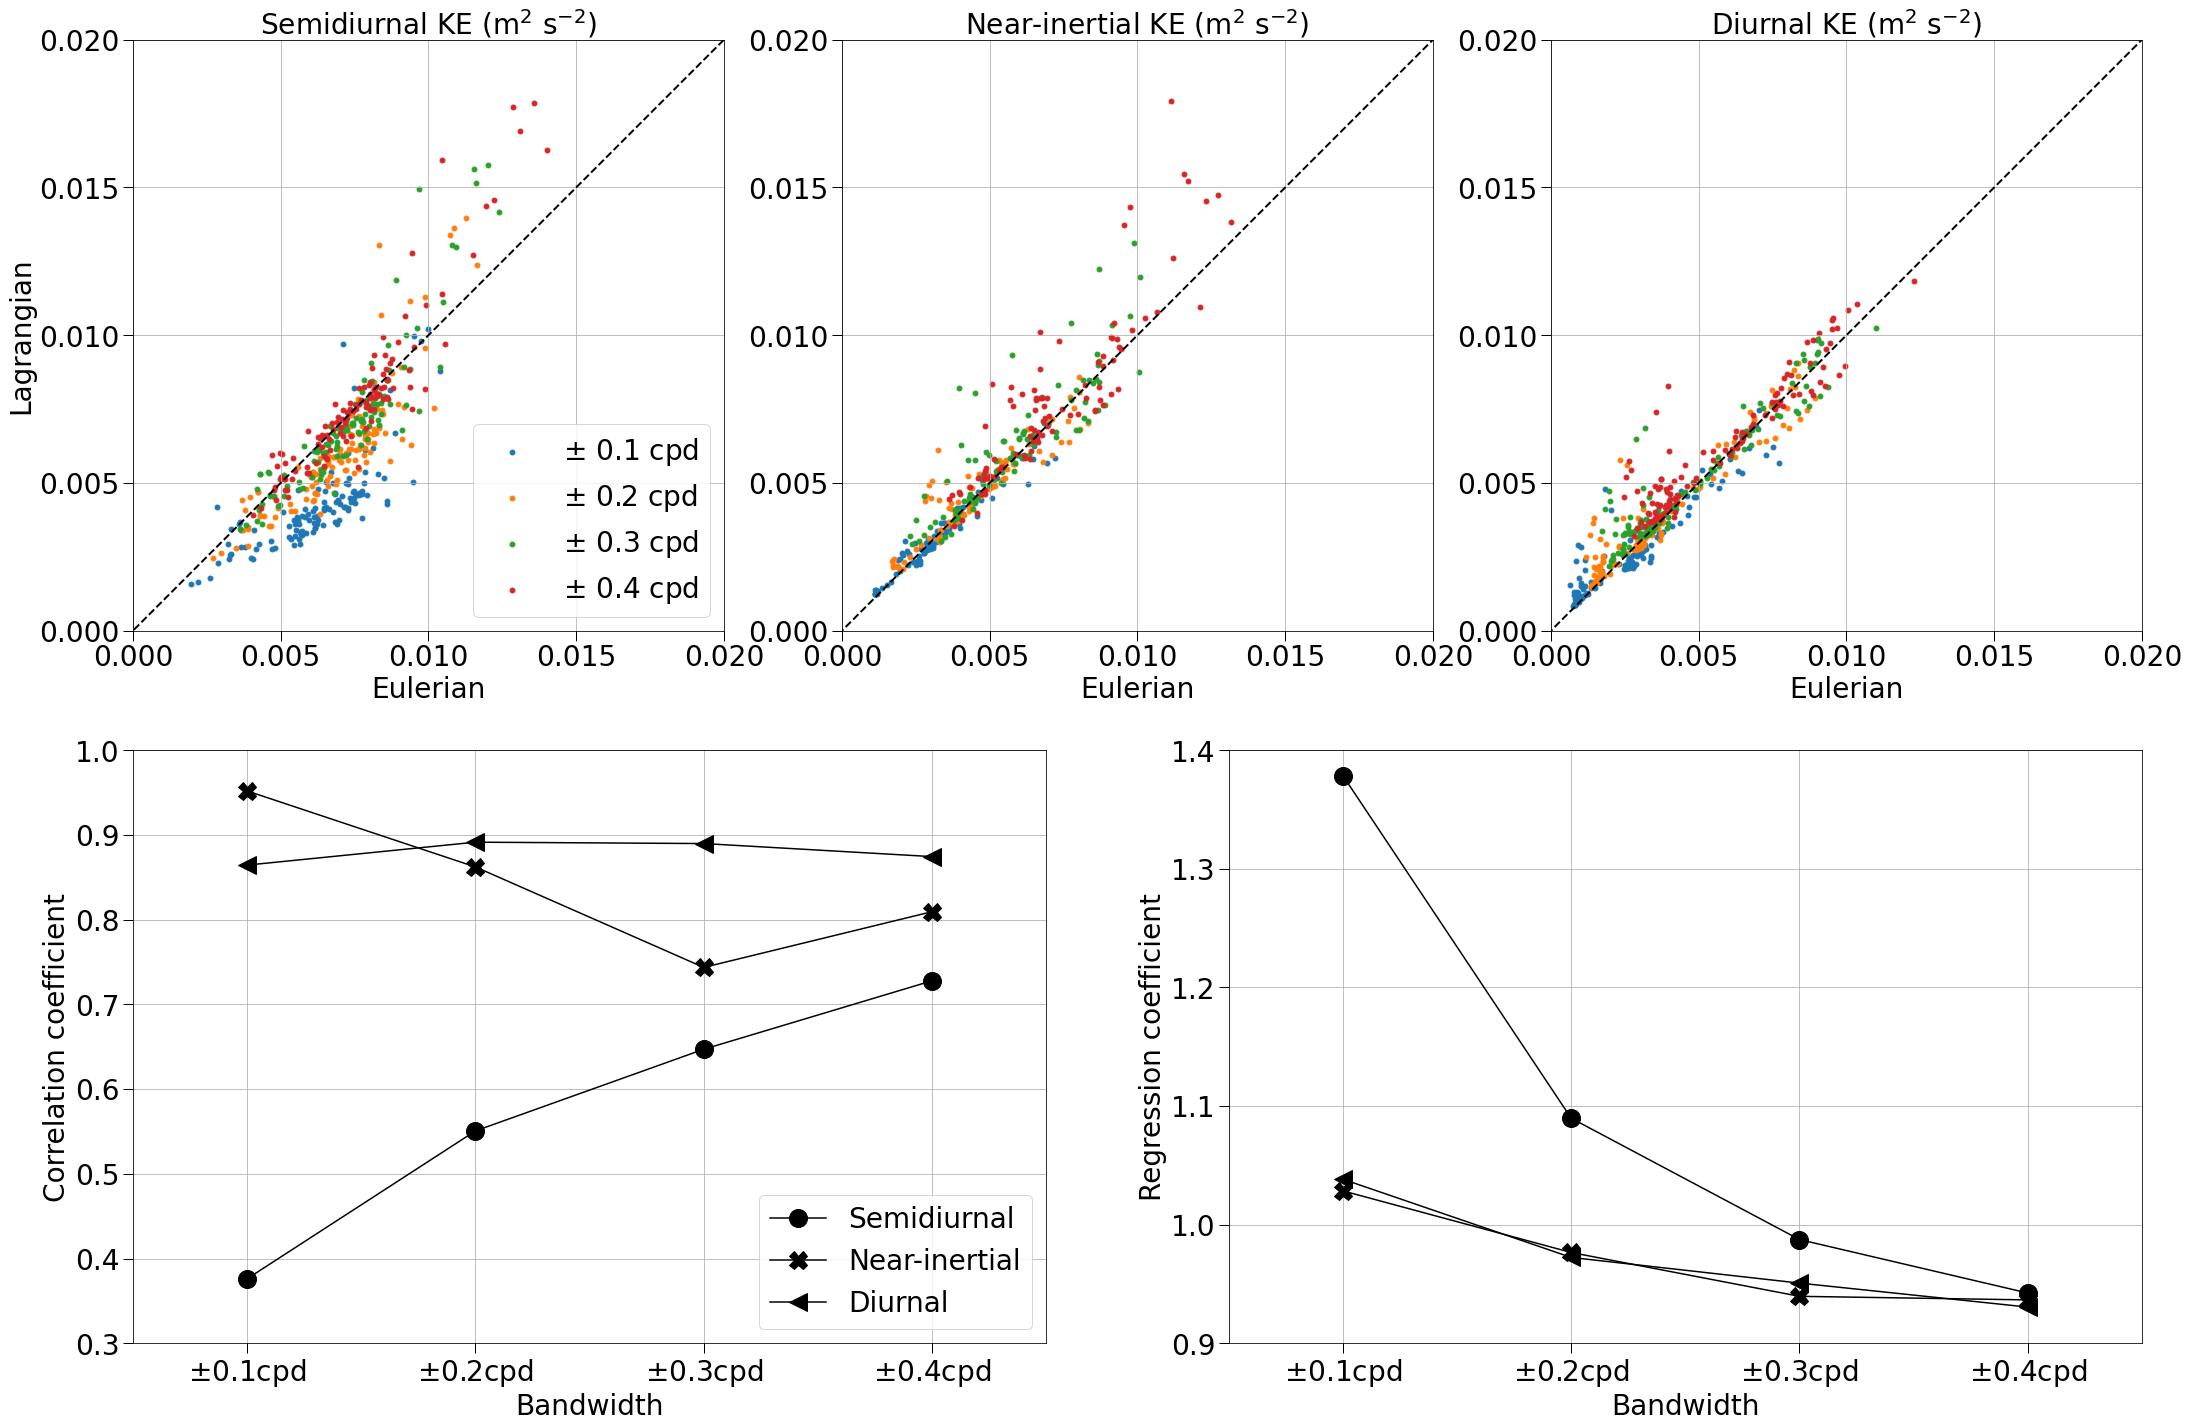

In [16]:
upper_limit= 0.2
lims =(-0.5, 0.5)
size = 24
font_size = 28
marker_size = 18
fig, ax = plt.subplots(1,1,figsize=(36,24))
labels = ['$\pm$ 0.1 cpd', '$\pm$ 0.2 cpd','$\pm$ 0.3 cpd','$\pm$ 0.4 cpd',]

ax = plt.subplot(231)
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), s=size, label=labels[0])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'), s=size, label=labels[1])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'), s=size, label=labels[2])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), s=size, label=labels[3])
ax.legend(prop={'size': font_size}); ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Semidiurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(232)
ax.scatter( E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(233)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

R_SD = [0.61337951**2, 0.74211037**2, 0.80442599**2, 0.85317599**2]
R_NI = [0.97568892**2, 0.92858213**2, 0.86238244**2, 0.89971512**2]
R_D =  [0.92977574**2, 0.94420776**2, 0.94334517**2, 0.9351458**2]
labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
ax = plt.subplot(223)
plt.plot(R_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(R_NI, '-X',label=labels[1],markersize=marker_size,color='black')
plt.plot(R_D, '-<',label=labels[2],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.3,1])
ax.grid()
ax.set_ylabel('Correlation coefficient',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower right', prop={'size': font_size})
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

ax = plt.subplot(224)
plt.plot(rc_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(rc_NI, '-X',label=labels[1],markersize=marker_size,color='black')
plt.plot(rc_D, '-<',label=labels[2],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.9,1.4])
ax.grid()
ax.set_ylabel('Regression coefficient',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_bandwidth_scatter_correlation_RC.png')

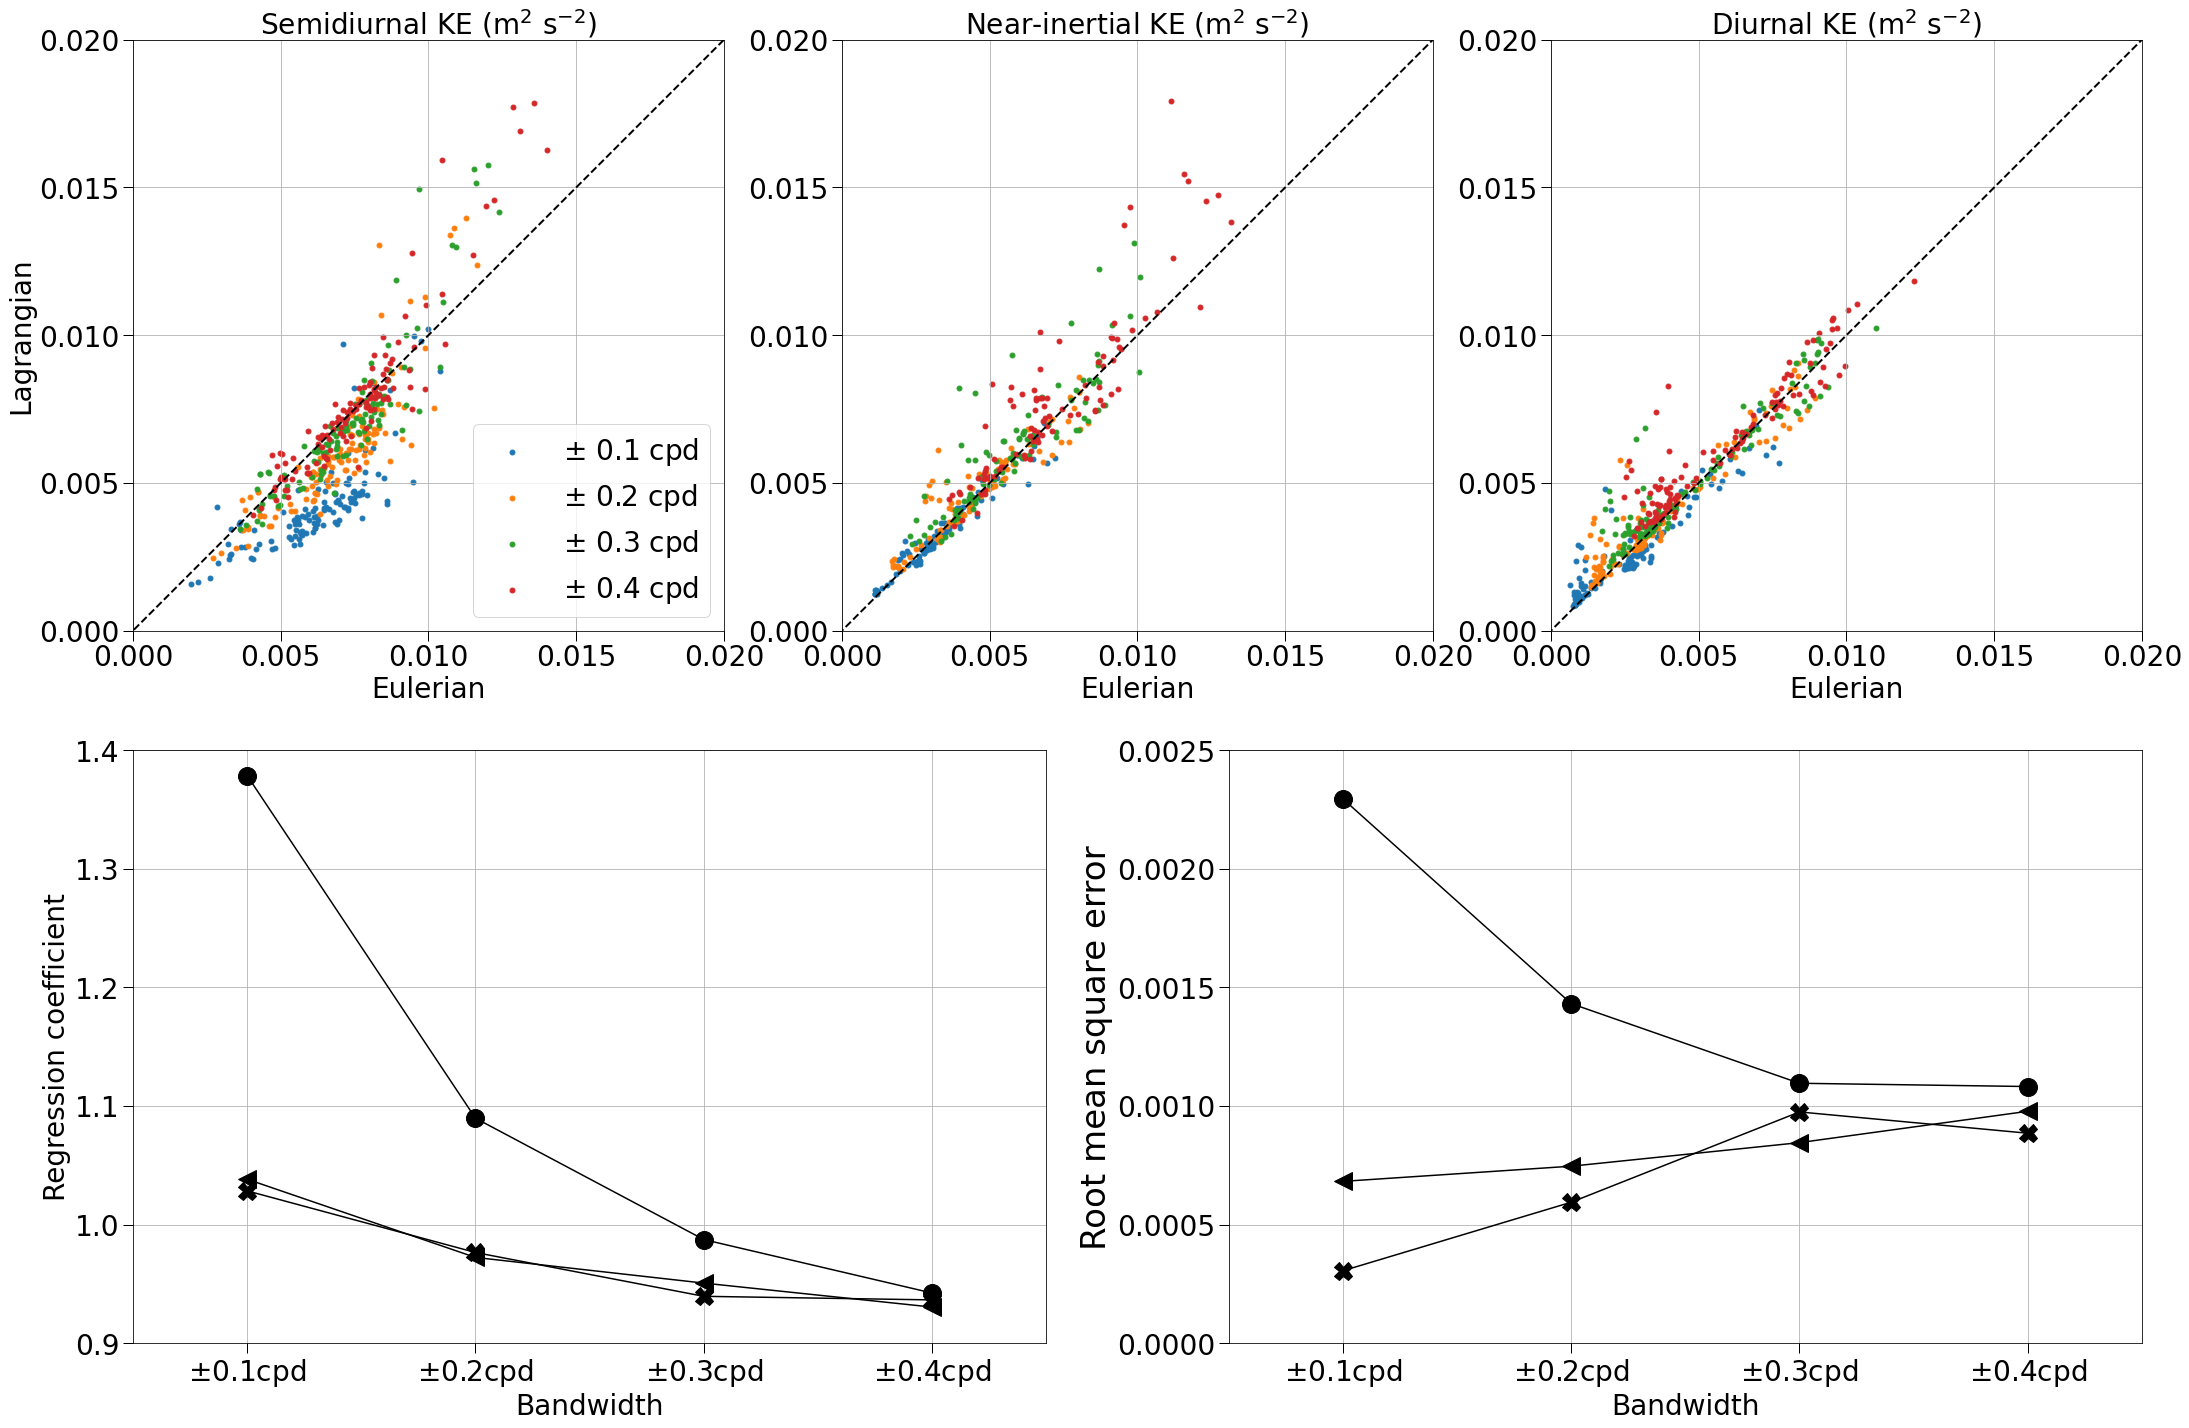

In [13]:
upper_limit= 0.2
lims =(-0.5, 0.5)
size = 24
font_size = 28
marker_size = 18
fig, ax = plt.subplots(1,1,figsize=(36,24))
labels = ['$\pm$ 0.1 cpd', '$\pm$ 0.2 cpd','$\pm$ 0.3 cpd','$\pm$ 0.4 cpd',]

ax = plt.subplot(231)
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), s=size, label=labels[0])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins'), s=size, label=labels[1])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins'), s=size, label=labels[2])
ax.scatter( E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'),E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), s=size, label=labels[3])
ax.legend(prop={'size': font_size}); ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Semidiurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(232)
ax.scatter( E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.scatter( E_E.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_E.lat_bins)>10),E_L.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(np.abs(E_L.lat_bins)>10), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(233)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins'), s=size)
ax.scatter( E_E.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins'), s=size)
ax.grid(); ax.set_xlim(0.,0.02); ax.set_ylim(0.,0.02)
ax.set_aspect('equal', 'box')
ax.set_xticks([0,0.005,0.01,0.015,0.02])
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(223)
plt.plot(rc_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(rc_NI, '-X',label=labels[1],markersize=marker_size,color='black')
plt.plot(rc_D, '-<',label=labels[2],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.9,1.4])
ax.grid()
ax.set_ylabel('Regression coefficient',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

RMSE_SD = [0.00229515, 0.00143207, 0.00109623, 0.00108246]
RMSE_NI = [0.00030586, 0.0005947 , 0.00097533, 0.00088564]
RMSE_D =  [0.00068269, 0.00074657, 0.00084595, 0.00097811]
ax = plt.subplot(224)
plt.plot(RMSE_SD, '-o',label=labels[0],markersize=marker_size,color='black')
plt.plot(RMSE_D, '-<',label=labels[2],markersize=marker_size,color='black')
plt.plot(RMSE_NI, '-X',label=labels[1],markersize=marker_size,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.,0.0025])
ax.grid()
ax.set_ylabel('Root mean square error',fontsize=font_size+6)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)
ax.set_xlabel('Bandwidth',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_bandwidth_scatter_RMSE_RC.png')

In [15]:
cluster.close()